In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO

from matplotlib import pyplot as plt
from scipy import stats

import glob

import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 12

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True


matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica Neue'
matplotlib.rcParams['font.weight']='ultralight'
matplotlib.rcParams['axes.axisbelow'] = True

In [4]:
from supporting_functions import *

# Read in basic information

In [5]:
prot_name = '3ip0'
distance_cutoff = 8.0
primary_chain_distance = 12

contact_file_loc = '../Data/Contact_matrices/{}_SCcenter_contacts.csv'.format(prot_name)
df_contacts = pd.read_csv(contact_file_loc, index_col=0)
df_contacts, df_contacts_stack = process_contacts_df(df_contacts, primary_chain_distance)


records = list(SeqIO.parse('../../Structural_analysis/ecoli_all_pdbs/wt_fastas/{}.fasta'.format(prot_name), 'fasta'))
assert len(records)==1
seq = str(records[0].seq)

df_couplings = pd.read_csv('../Data/Simulated_couplings/3ip0_ALL_thresh=0.5_nMuts=3160_nSeqs=3000.couplings', sep=' ', header=None)
df_couplings, df_couplings_pivot, df_couplings_stack = process_couplings_df(df_couplings, df_contacts, primary_chain_distance)
merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)

In [6]:
merged_df.head()

,aa1_loc,aa2_loc,distance,primary_chain_distance,couplings,aa1_aa,aa2_aa
10424,122,152,4.061325,30,1.756403,G,F
3962,31,60,5.109784,29,0.831960,S,L
191,2,59,5.614795,57,0.784406,V,A
8455,80,94,4.591123,14,0.759161,Q,L
10509,126,147,4.598157,21,0.736417,W,L


# Correlation between couplings and contacts

SpearmanrResult(correlation=0.036411986092040306, pvalue=0.00016145875626785182)


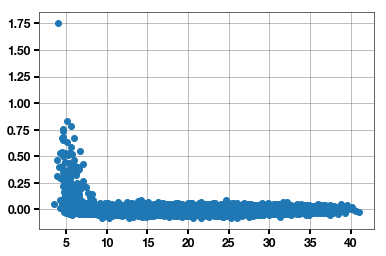

In [7]:
plt.figure()
plt.scatter(merged_df['distance'], (merged_df['couplings']))
print(stats.spearmanr(merged_df['distance'], merged_df['couplings']))

# Varying parameters

In [10]:
contact_number_modifier = 0.5
number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
length_cutoff = 8
thresholds = [str(i) for i in [0.1, 0.3, 0.5, 0.7, 0.9]]
nMut = len(df_contacts.index)*20
ppvs_dict = {}
metrics = ['CA', 'SCcenter']
for metric in metrics:
    ppvs_lol = []
    contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
    df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, primary_chain_distance)
    for threshold in thresholds:
        cat_ppvs = []
        for nSeq in list(range(100, 501, 100)) + list(range(1000, 3001, 500)):
            file_loc = '../Data/Simulated_couplings/3ip0_ALL_thresh={}_nMuts={}_nSeqs={}.couplings'.format(threshold, nMut, nSeq)
            print(file_loc)
            df_couplings = pd.read_csv(file_loc, sep=' ', header=None)
            df_couplings, df_couplings_pivot, df_couplings_stack = process_couplings_df(df_couplings, df_contacts, primary_chain_distance)
            merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)
            ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=length_cutoff)
            cat_ppvs.append(ppv)
        ppvs_lol.append(cat_ppvs)
    ppvs_dict[metric] = ppvs_lol

../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=100.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=200.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=300.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=400.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=500.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=1000.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=1500.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=2000.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=2500.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=3000.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.3_nMuts=3160_nSeqs=100.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.3_nMuts=3160_nSeqs=200.couplings
../Data/Simulated_couplings/3ip0_ALL_thresh=0.3

# Paper figure/s

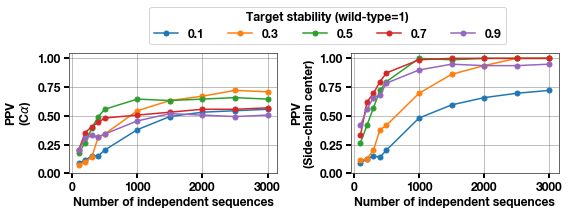

In [12]:
fig, all_ax = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))
x_vals = np.concatenate((np.arange(100, 501, 100), np.arange(1000, 3001, 500)))
labels = thresholds

ax = all_ax[0]
for i,ppvs in enumerate(ppvs_dict[metrics[0]]):
    ax.plot(x_vals, ppvs, marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)
ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
ax.set_xlabel('Number of independent sequences')
ax.set_ylim(0, 1.05);

ax = all_ax[1]
for i,ppvs in enumerate(ppvs_dict[metrics[1]]):
    ax.plot(x_vals, ppvs, marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)
ax.set_ylabel(r'PPV''\n'r'(Side-chain center)')

ax.set_xlabel('Number of independent sequences')
ax.set_ylim(0, 1.05);
legend = ax.legend(ncol=5, bbox_to_anchor=(-1, 1.02, 1., .102), loc=3, fontsize=12, title='Target stability (wild-type=1)')
legend.get_title().set_fontsize('12') #legend 'Title' fontsize
plt.tight_layout()


plt.savefig('{}/example_all_sims_nseqs.pdf'.format(figs_dir), bbox_inches='tight')

# Presentation Figure/s

**Just show Sim of 0.5**

In [ ]:
fig, all_ax = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))
x_vals = np.concatenate((np.arange(100, 501, 100), np.arange(1000, 3001, 500)))
labels = thresholds

ax = all_ax[0]
for i,tprs in enumerate(tprs_dict[metrics[0]]):
    if i == 2:
        ax.plot(x_vals, tprs, c='g', marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)
ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
ax.set_xlabel('Number of independent sequences')
ax.set_ylim(0, 1.05);

ax = all_ax[1]
for i,tprs in enumerate(tprs_dict[metrics[1]]):
    if i == 2:
        ax.plot(x_vals, tprs, c='g', marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)
ax.set_ylabel(r'PPV''\n'r'(Side-chain center)')

ax.set_xlabel('Number of independent sequences')
ax.set_ylim(0, 1.05);
legend = ax.legend(ncol=5, bbox_to_anchor=(-0.6, 1.02, 1., .102), loc=3, fontsize=12, title='Simulation threshold')
legend.get_title().set_fontsize('12') #legend 'Title' fontsize
plt.tight_layout()


plt.savefig('{}/example_single_sim_nseqs.pdf'.format(figs_dir), bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4,2.5))
x_vals = np.concatenate((np.arange(100, 501, 100), np.arange(1000, 3001, 500)))
labels = thresholds

for i,tprs in enumerate(tprs_dict[metrics[0]]):
    if i == 2:
        ax.plot(x_vals, tprs, c='g', marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)
ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
ax.set_xlabel('Number of independent sequences')
ax.set_ylim(0, 1.05);
# legend = ax.legend(ncol=5, bbox_to_anchor=(-0.6, 1.02, 1., .102), loc=3, fontsize=12, title='Simulation threshold')
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title='Simulation threshold')
legend.get_title().set_fontsize('12') #legend 'Title' fontsize
plt.tight_layout()
plt.savefig('{}/example_single_sim_nseqs_left.pdf'.format(figs_dir), bbox_inches='tight')


fig, ax = plt.subplots(figsize=(4,2.5))
x_vals = np.concatenate((np.arange(100, 501, 100), np.arange(1000, 3001, 500)))
labels = thresholds
for i,tprs in enumerate(tprs_dict[metrics[0]]):
    ax.plot(x_vals, tprs, marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)
ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
ax.set_xlabel('Number of independent sequences')
ax.set_ylim(0, 1.05);
# legend = ax.legend(ncol=5, bbox_to_anchor=(-0.6, 1.02, 1., .102), loc=3, fontsize=12, title='Simulation threshold')
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title='Simulation threshold')
legend.get_title().set_fontsize('12') #legend 'Title' fontsize
plt.tight_layout()
plt.savefig('{}/example_all_sim_nseqs_left.pdf'.format(figs_dir), bbox_inches='tight')




# Fixed sequence number, altered mutation number

In [14]:
contact_number_modifier = 0.5
number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
length_cutoff = 8
thresholds = [str(i) for i in [0.1, 0.3, 0.5, 0.7, 0.9]]
nSeq = 3000

records = list(SeqIO.parse('../../Structural_analysis/ecoli_all_pdbs/wt_fastas/3ip0.fasta', 'fasta'))
assert len(records)==1
seq = str(records[0].seq)

ppvs_dict = {}
for metric in metrics:
    ppvs_lol = []
    contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
    df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, primary_chain_distance)
    for threshold in thresholds:
        cat_ppvs = []
        for nMut in list(range(1,6,1))+list(range(10,21,5)):
            print(nMut)
            file_loc = '../Data/Simulated_couplings/3ip0_ALL_thresh={}_nMuts={}_nSeqs={}.couplings'.format(threshold, nMut*len(df_contacts.index), nSeq)
            print(file_loc)
            df_couplings = pd.read_csv(file_loc, sep=' ', header=None)
            df_couplings, df_couplings_pivot, df_couplings_stack = process_couplings_df(df_couplings, df_contacts, primary_chain_distance)
            merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)
            ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=length_cutoff)
            cat_ppvs.append(ppv)
        ppvs_lol.append(cat_ppvs)
    ppvs_dict[metric] = ppvs_lol

1
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=158_nSeqs=3000.couplings
2
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=316_nSeqs=3000.couplings
3
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=474_nSeqs=3000.couplings
4
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=632_nSeqs=3000.couplings
5
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=790_nSeqs=3000.couplings
10
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=1580_nSeqs=3000.couplings
15
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=2370_nSeqs=3000.couplings
20
../Data/Simulated_couplings/3ip0_ALL_thresh=0.1_nMuts=3160_nSeqs=3000.couplings
1
../Data/Simulated_couplings/3ip0_ALL_thresh=0.3_nMuts=158_nSeqs=3000.couplings
2
../Data/Simulated_couplings/3ip0_ALL_thresh=0.3_nMuts=316_nSeqs=3000.couplings
3
../Data/Simulated_couplings/3ip0_ALL_thresh=0.3_nMuts=474_nSeqs=3000.couplings
4
../Data/Simulated_couplings/3ip0_ALL_thresh=0.3_nMuts=632_nSeqs=3000.couplings
5
../Data/Simulated_co

# Paper figure/s

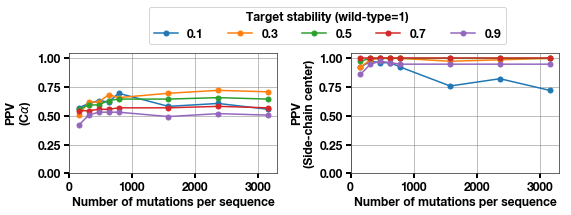

In [16]:
fig, all_ax = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))
x_vals = [i*len(df_contacts.index) for i in list(range(1,6,1))+list(range(10,21,5))]
labels = thresholds

ax = all_ax[0]
for i,ppvs in enumerate(ppvs_dict[metrics[0]]):
    ax.plot(x_vals, ppvs, marker='o', label=thresholds[i], markersize=5)
ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
ax.set_xlabel('Number of mutations per sequence')
ax.set_ylim(0, 1.05);

ax = all_ax[1]
for i,ppvs in enumerate(ppvs_dict[metrics[1]]):
    ax.plot(x_vals, ppvs, marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)
ax.set_ylabel(r'PPV''\n'r'(Side-chain center)')

ax.set_xlabel('Number of mutations per sequence')
ax.set_ylim(0, 1.05);
legend = ax.legend(ncol=5, bbox_to_anchor=(-1, 1.02, 1., .102), loc=3, fontsize=12, title='Target stability (wild-type=1)')
legend.get_title().set_fontsize('12') #legend 'Title' fontsize
plt.tight_layout()

plt.savefig('{}/example_all_sims_nmuts.pdf'.format(figs_dir), bbox_inches='tight')

# Presentation figures

In [ ]:
fig, all_ax = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))
x_vals = [i*len(df_contacts.index) for i in list(range(1,6,1))+list(range(10,21,5))]
labels = thresholds

ax = all_ax[0]
for i,tprs in enumerate(tprs_dict[metrics[0]]):
    if i not in [2]:
        continue
    ax.plot(x_vals, tprs, c='g', marker='o', label=thresholds[i], markersize=5)
ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
ax.set_xlabel('Number of mutations per sequence')
ax.set_ylim(0, 1.05);

ax = all_ax[1]
for i,tprs in enumerate(tprs_dict[metrics[1]]):
    if i not in [2]:
        continue
    ax.plot(x_vals, tprs, c='g', marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)
ax.set_ylabel(r'PPV''\n'r'(Side-chain center)')

ax.set_xlabel('Number of mutations per sequence')
ax.set_ylim(0, 1.05);
legend = ax.legend(ncol=5, bbox_to_anchor=(-0.55, 1.02, 1., .102), loc=3, fontsize=12, title='Simulation threshold')
legend.get_title().set_fontsize('12') #legend 'Title' fontsize
plt.tight_layout()

plt.savefig('{}/example_single_sims_nmuts.pdf'.format(figs_dir), bbox_inches='tight')

# Sequence identity with mutation distance

In [ ]:
df = pd.read_csv('../Results/hamming_distances.csv', index_col=0)
df.head()

In [ ]:
file_pattern = '../Results/1B4T_A/fastas/1B4T_A_ALL_thresh=XXX_nMuts=YYY.fasta'
dicty = {}
nMuts = list(range(100, 501, 100)) + list(range(1000, 5001, 500))
thresh_vals = [0.3, 0.5, 0.7]

for thresh in thresh_vals:
    dicty[thresh] = []
    for nMut in nMuts:
        hamming = df.loc[file_pattern.replace('XXX', str(thresh)).replace('YYY', str(nMut))]['i']
        similarity = (len(df_contacts.index)-np.array(hamming))/len(df_contacts.index)
        dicty[thresh].append(similarity)

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
for thresh in thresh_vals:
    ax.plot(nMuts, dicty[thresh], marker='s', label='{}'.format(thresh))
ax.set_ylim(0,1)
ax.tick_params(labelsize=16)
ax.set_xlabel('Number of accepted mutations', fontsize=16)
ax.set_ylabel('Similarity', fontsize=16)
legend = ax.legend(title="Simulation threshold", fontsize=14, ncol=3, loc='upper center')
plt.setp(legend.get_title(),fontsize=16);

plt.savefig('../Results/Figures/similarity.png', bbox_inches='tight')

In [ ]:
df_couplings.head()

# Scratch

**Steady state amino acid levels**

In [ ]:
from Bio.Data import CodonTable
def get_codon_dicts(n=11):
    GivenCodonTable = CodonTable.unambiguous_dna_by_id[n]
    nucleotides = ['A', 'T', 'C', 'G']
    aa_to_codons = {}
    for first in nucleotides:
        for second in nucleotides:
            for third in nucleotides:
                Codon = first + second + third
                if Codon not in CodonTable.unambiguous_dna_by_id[n].stop_codons:
                    if GivenCodonTable.forward_table[Codon] in aa_to_codons.keys():
                            aa_to_codons[GivenCodonTable.forward_table[Codon]].append(Codon)
                    else:
                        aa_to_codons[GivenCodonTable.forward_table[Codon]] = [Codon]
                else:
                    pass
    codon_to_aa = {}
    for aa, syns in aa_to_codons.items():
        for syn in syns:
            codon_to_aa[syn] = aa
    return aa_to_codons, codon_to_aa
aa_to_codons, codon_to_aa = get_codon_dicts()

In [ ]:
df = pd.read_csv('../Results/avg_aa_counts.csv', index_col=0)
df.fillna(value=0, inplace=True)

totals = df.loc['WT'].sum()
df.loc['Idealized'] = np.nan
for column in df.columns:
    df.set_value('Idealized', column, len(aa_to_codons[column])/61*totals)
df["new"] = range(1,len(df)+1)
df.set_value('Idealized','new',0)
df.set_value('WT','new',0)
df = df.sort_values("new").drop('new', axis=1)
df.head()

In [ ]:
thresh = 0.7
file_pattern = '../Results/1B4T_A/fastas/1B4T_A_ALL_thresh={}_nMuts=XXX.fasta'.format(thresh)

In [ ]:
nMuts = list(range(100, 501, 100))+list(range(1000, 5001, 500))
rhos = []
for nMut in nMuts:
    index = file_pattern.replace('XXX', str(nMut))
    print(index)
#     print(list(df.loc[index]))
    rho, p = stats.spearmanr(list(df.loc['Idealized']), list(df.loc[index]))
    rhos.append(rho)

In [ ]:
wt_rho, p = stats.spearmanr(list(df.loc['Idealized']), list(df.loc['WT']))

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(nMuts, rhos, 'bo')
ax.axhline(wt_rho, c='r', linestyle='--')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(df.loc['Idealized'], df.loc[file_pattern.replace('XXX', str(5000))], 'co')
ax.plot(df.loc['Idealized'], df.loc['WT'], 'ko')
ax.plot([0, 25], [0, 25], 'r-')


# Scratch

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
merged_df['contact'] = np.where(merged_df['distance']>=8, 0, 1)

In [ ]:
precision, recall, thresholds = precision_recall_curve(merged_df['contact'], merged_df['couplings'])
print(average_precision_score(merged_df['contact'], merged_df['couplings']))

In [ ]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')